In [2]:
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

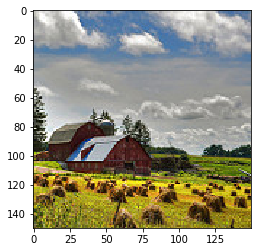

In [4]:
img = plt.imread('./scene.jpg')
plt.imshow(img)

In [8]:
def preprocess(img):
    img4d = img.copy()
    img4d = img4d.astype("float64")
    if K.image_dim_ordering() == "th":
        # (H, W, C) -> (C, H, W)
        img4d = img4d.transpose((2, 0, 1))
    img4d = np.expand_dims(img4d, axis=0)
    img4d = vgg16.preprocess_input(img4d)
    return img4d

def deprocess(img4d):
    img = img4d.copy()
    if K.image_dim_ordering() == "th":
        # (B, C, H, W)
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
        # (C, H, W) -> (H, W, C)
        img = img.transpose((1, 2, 0))
    else:
        # (B, H, W, C)
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # BGR -> RGB
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Original image shape: (150, 150, 3)
After preprocess: (1, 150, 150, 3)
After deprocess: (150, 150, 3)


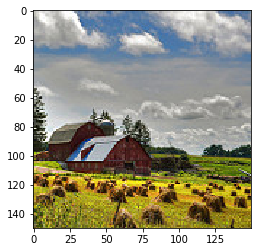

In [10]:
img = plt.imread('./scene.jpg')
plt.imshow(img)
img_copy = img.copy()
print("Original image shape:", img.shape)
p_img = preprocess(img_copy)
print("After preprocess:", p_img.shape)
d_img = deprocess(p_img)
print("After deprocess:", d_img.shape)
plt.imshow(d_img)
plt.show()

In [12]:
# load pretrained VGG-16
batch_shape = p_img.shape
batch_shape

(1, 150, 150, 3)

In [13]:
dream = Input(batch_shape=batch_shape)
model = vgg16.VGG16(input_tensor=dream, weights="imagenet", include_top=False)
# create layer name to layer dictionary
layer_dict = {layer.name : layer for layer in model.layers}

58859520/58889256 [============================>.] - ETA: 0s

In [16]:
layer_dict.keys()

dict_keys(['block5_conv2', 'block4_conv2', 'block1_conv2', 'block2_conv2', 'block1_conv1', 'block3_conv1', 'block3_pool', 'block3_conv3', 'block4_conv3', 'block1_pool', 'block4_pool', 'block5_conv3', 'block3_conv2', 'block4_conv1', 'input_1', 'block2_pool', 'block2_conv1', 'block5_conv1', 'block5_pool'])

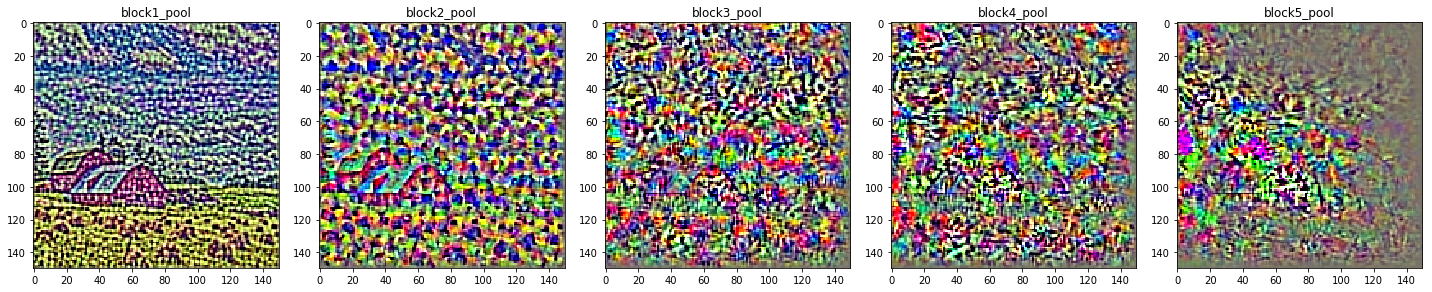

In [15]:
num_pool_layers = 5
lr = 0.01
fig, axes = plt.subplots(1, num_pool_layers, figsize=(20, 10))
for i in range(num_pool_layers):
    layer_name = "block{:d}_pool".format(i + 1)
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output)
    grads = K.gradients(loss, dream)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) * lr
    f = K.function([dream], [loss, grads])
    img_value = p_img.copy()
    loss_value, grads_value = f([img_value])
    axes[i].set_title(layer_name)
    axes[i].imshow(deprocess(grads_value))

plt.tight_layout()
plt.show()

block5_pool (1, 4, 4, 512)
Pooling Layer: block1_pool


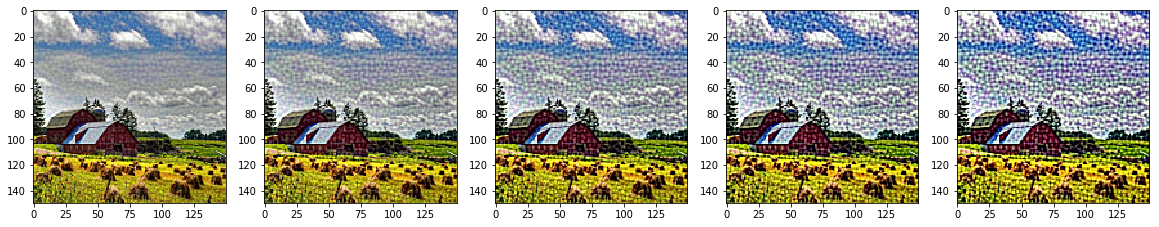

Pooling Layer: block2_pool


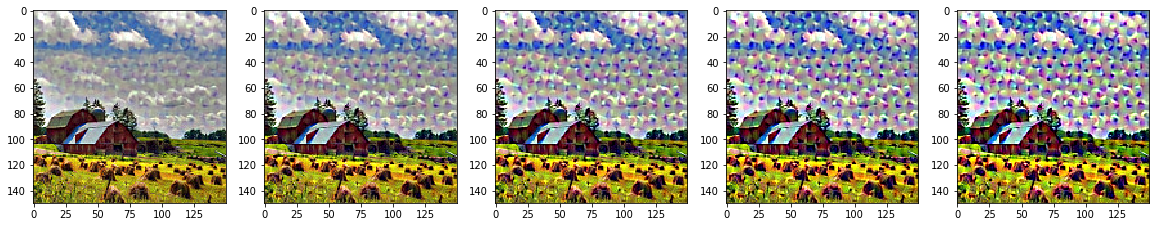

Pooling Layer: block3_pool


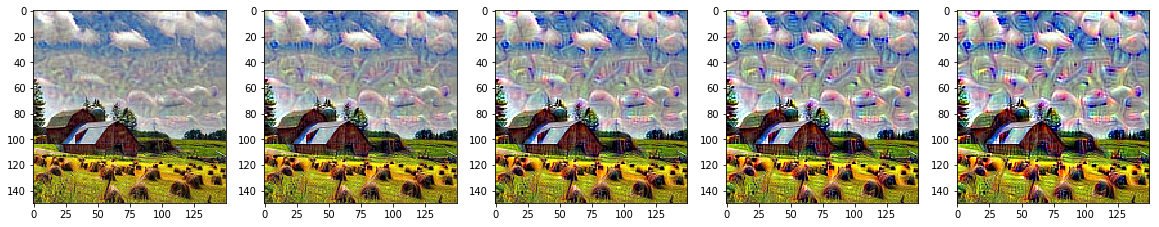

Pooling Layer: block4_pool


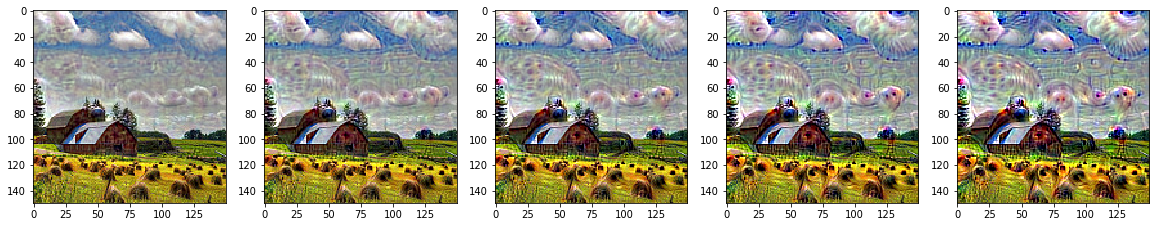

Pooling Layer: block5_pool


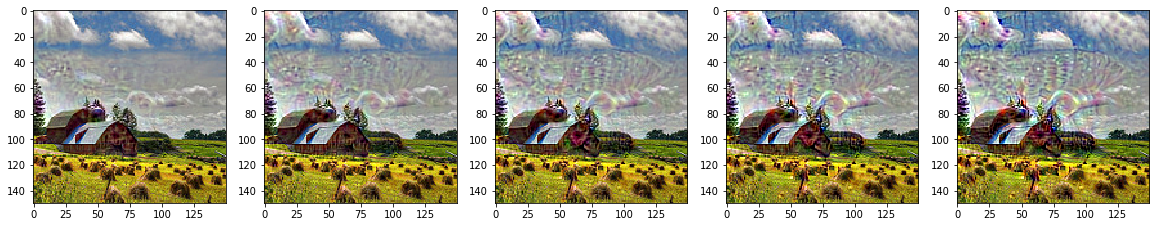

In [18]:
# deep dreaming
first_layer = model.layers[-1]
input_img = first_layer.input
print(first_layer.name, first_layer.output_shape)

num_pool_layers = 5
num_iters_per_layer = 5
step = 10

for i in range(num_pool_layers):
    layer_name = "block{:d}_pool".format(i+1)
    print("Pooling Layer: {:s}".format(layer_name))
    layer_output = layer_dict[layer_name].output
    # loss function
    loss = K.mean(layer_output)
    # gradient
    grads = K.gradients(loss, dream)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # optimizer
    f = K.function([dream], [loss, grads])
    img_value = p_img.copy()
    fig, axes = plt.subplots(1, num_iters_per_layer, figsize=(20, 10))
    for it in range(num_iters_per_layer):
        loss_value, grads_value = f([img_value])
        img_value += grads_value * step 
        axes[it].imshow(deprocess(img_value))
    plt.show()